# Phase Retrieval in dLux

In this notebook, we will go through a simple example of phase retrieval in dLux, just recovering Zernike coefficients for an aberrated circular aperture by gradient descent.

First, we import the necessary packages, including `Jax`:

In [1]:
# jax core code
import jax
import jax.numpy as np

# jax third party packages
import equinox as eqx # object-oriented jax
import optax # jax optimization code

# misc
from tqdm.notebook import tqdm
import numpy as onp

# dLux functions
import dLux as dl
from dLux import *
from dLux.utils.helpers import *
from dLux.utils.zernike import zernike_basis

# Plotting code
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configure plots
%matplotlib inline 
cmap = mpl.cm.get_cmap("inferno").copy()
cmap.set_bad('k',1.)
plt.rcParams['image.cmap'] = cmap
plt.rcParams["text.usetex"] = 'false'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

# Set seed for repeatability
onp.random.seed(0)

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


Now, we initialize the parameters: a 1m telescope, in focus, with a broadband bandpass.

We also generate a Zernike basis, omitting the piston/tip/tilt elements, and generate some random aberrations as normally-distributed coefficients over that basis. 

As noted by [Martinache et al 2013](https://ui.adsabs.harvard.edu/abs/2013PASP..125..422M/abstract), you can only detect the sign of even-order aberrations if your pupil is not inversion-symmetric; so following that paper, we introduce a small bar asymmetry.

In [2]:
# Basic Optical Parameters
aperture = 1.
fl = 10.     
wf_npix = 128 

# Spectral Params
min_wavel = 450e-9
max_wavel = 550e-9
wavels = np.linspace(min_wavel, max_wavel, 5)

# Zernike Parameters
basis = zernike_basis(11, 128, outside=0.)[3:]
coeffs = norm_rand(0, 2e-8, len(basis))

# Detector Parameters
det_npix = 512 
det_pixsize = nyquist_pix_airy(4, np.mean(wavels), aperture, fl)

# Generate an asymmetry
asymmetry = np.ones((wf_npix,wf_npix))
asymmetry = asymmetry.at[56:72,0:56].set(0)

Here is the core syntax of `dLux`: a list of optical layers. Unlike some other systems, we are *very* explicit about the whole optical system: so we first initialize a wavefront, then specify its centring with a `TiltWavefront` layer (default is centred, but could represent an off-axis source with arguments). 

Then we pass it through a circular aperture of radius filling the whole input wavefront, and then the asymmetry: you can simply stack these and it will apply them sequentially. We then normalize the flux, and apply the Zernike aberrations with `ApplyBasisOPD`. The final layer is then `PhysicalMFT` (which maps pupil to focal planes, as opposed to `AngularMFT`, which maps focal to pupil planes). 

In [3]:
optical_layers = [
    CreateWavefront    (wf_npix, aperture),
    TiltWavefront      (),
    CircularAperture   (wf_npix),
    TransmissiveOptic  (asymmetry),
    NormaliseWavefront (),
    ApplyBasisOPD      (basis, coeffs),
    PhysicalMFT        (det_npix, fl, det_pixsize)]

mask = 1.0*((optical_layers[2].array*asymmetry) > 1e-5) # for visualization, have a nan mask
mask = mask.at[mask==False].set(np.nan)

Then an optical system is an `equinox` module which you initialize with a list of layers and a bandpass, and then the `__call__` function simply generates the PSF.

In [4]:
osys = OpticalSystem(optical_layers,wavels=wavels)

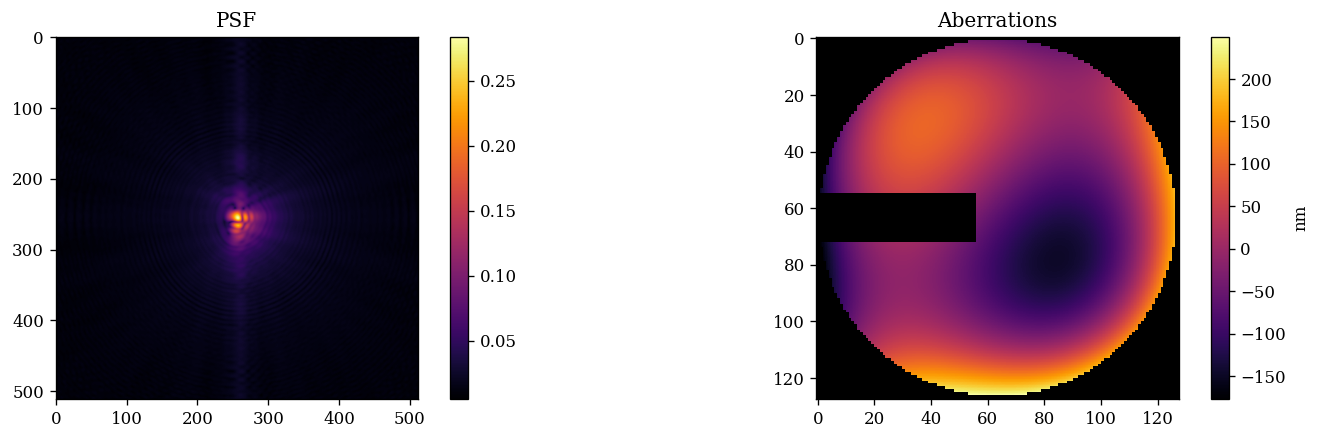

In [5]:
psf = osys()

aberr_in = optical_layers[5].get_total_opd()

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 2)
plt.title("Aberrations")
plt.imshow(mask*aberr_in*1e9)
plt.colorbar(label='nm')

plt.subplot(1, 2, 1)
plt.title("PSF")
plt.imshow(psf**0.25)
plt.colorbar()
plt.show()

Now let's init an identical optical system but with the wrong Zernikes, and see if we can learn the right ones by gradient descent.

In [6]:
coeffs_init = norm_rand(0, 2e-8, len(basis))

init_layers = [
    CreateWavefront    (wf_npix, aperture),
    TiltWavefront      (),
    CircularAperture   (wf_npix),
    TransmissiveOptic  (asymmetry),
    NormaliseWavefront (),
    ApplyBasisOPD      (basis, coeffs_init),
    PhysicalMFT        (det_npix, fl, det_pixsize)]

model = OpticalSystem(init_layers,wavels)
init_psf = model()

For the moment, we will use some slightly ungainly syntax to set which parameters are to be optimized - this is using the default `equinox` syntax but future versions of dLux will have a nicer frontend.

In [7]:
# Default values to group 0
filter_spec = jax.tree_map(lambda _: False, model)

# Set filtering Tree
filter_spec = eqx.tree_at(lambda model: model.layers[5].coeffs, filter_spec, replace=True)

In [8]:
@eqx.filter_jit(fn=eqx.is_inexact_array)
@eqx.filter_value_and_grad(arg=filter_spec)
def loss_func(model, data):
    out = model()
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

We can time this - even on CPU it is fast! We want to do a first call so that the loss function is `jit` compiled.

In [9]:
%%timeit
loss, initial_grads = loss_func(model, psf) # Compile

29.2 ms ± 687 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
loss, initial_grads = loss_func(model, psf) 
print("Initial Loss: {}".format(loss))

Initial Loss: 8.167550086975098


Now begin the optimization loop using `optax` with a low learning rate. 

In [11]:
optim = optax.adam(2e-9)
opt_state = optim.init(model)

errors, grads_out, models_out = [], [], []

with tqdm(range(100),desc='Gradient Descent') as t:
    for i in t: 
        # calculate the loss and gradient
        loss, grads = loss_func(model, psf) 
        
        # apply the update
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        
        # save results
        models_out.append(model) 
        errors.append(loss)
        grads_out.append(grads)
        
        t.set_description('Loss %.5f' % (loss)) # update the progress bar
        
final_psf = model()

Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

Now we visualize this: we have great performance, recovering the input Zernike coefficients accurately and a beautiful PSF recovery.

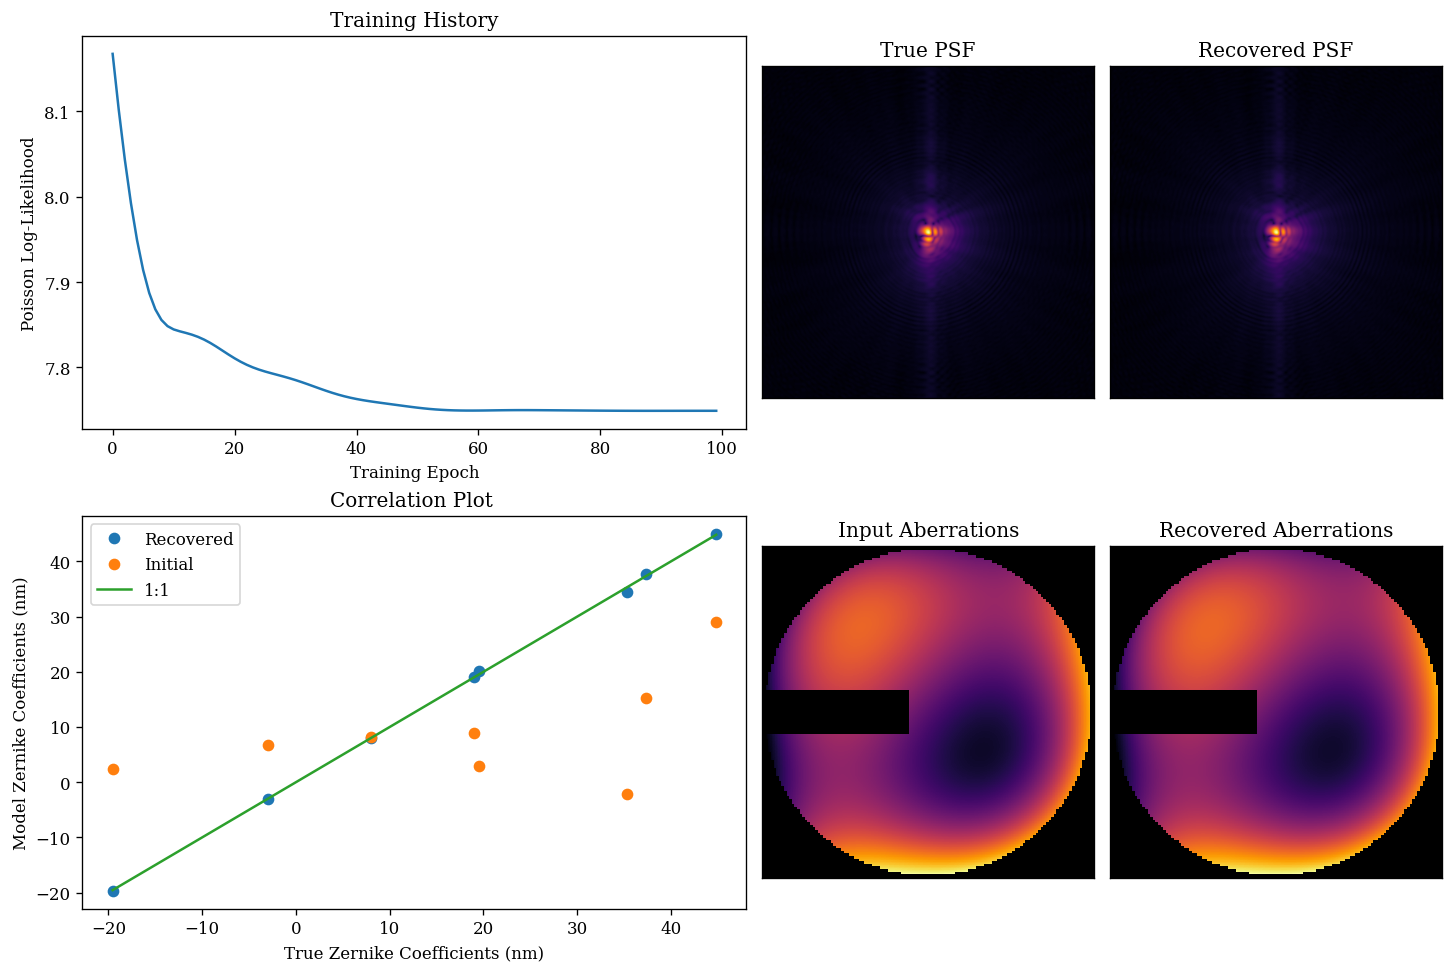

In [12]:
coeffs_out = np.array([model_out.layers[5].coeffs for model_out in models_out])

mosaic = """
    AABD
    GGEF
    """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['B','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])

axes['A'].plot(np.array(errors))
axes['A'].set_title("Training History")
axes['A'].set_xlabel('Training Epoch')
axes['A'].set_ylabel('Poisson Log-Likelihood')

axes['B'].imshow(psf**0.25)
axes['B'].set_title('True PSF')

axes['G'].plot(coeffs*1e9,model.layers[5].coeffs*1e9,'.',markersize=12,color='C0',label='Recovered')
axes['G'].plot(coeffs*1e9,coeffs_init*1e9,'.',markersize=12,color='C1',label='Initial')

axes['G'].plot(np.array([np.min(coeffs),np.max(coeffs)])*1e9,
               np.array([np.min(coeffs),np.max(coeffs)])*1e9,
               '-',color='C2',label='1:1')
axes['G'].legend()
axes['G'].set_title('Correlation Plot ')
axes['G'].set_xlabel('True Zernike Coefficients (nm)')
axes['G'].set_ylabel('Model Zernike Coefficients (nm)')

axes['D'].imshow(final_psf**0.25)
axes['D'].set_title('Recovered PSF')

axes['E'].imshow(mask*aberr_in)
axes['E'].set_title('Input Aberrations')

axes['F'].imshow(mask*model.layers[5].get_total_opd())
axes['F'].set_title('Recovered Aberrations')
plt.show()